In [29]:
import math
import random

import numpy as np
from numba import njit, prange

import matplotlib.pyplot as plt

In [30]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int):
        data = []
    
        for i in range(n):
            angle = random.uniform(0, 2*math.pi)
            dist = random.uniform(r1, r2)

            data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
        
        return np.array(data)

def gen_circle_smaple(c: tuple, r: float, n: int):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return np.array(data)

In [31]:
@njit
def reduce_density(points: np.ndarray, sep_factor: float, niter: int):
    npts = points.shape[0]
    
    for k in prange(niter):
        
        forces = np.zeros(points.shape, np.float32)
        
        for i in prange(npts):        
            dp = np.sum(np.square(points[i]-points), axis=1).reshape((npts, 1))
            forces[i] = 1/npts*np.sum(np.exp(-sep_factor*dp)*(points[i]-points), axis=0)
        
        points += forces

In [32]:
@njit
def update_positions(x: np.ndarray, p: np.ndarray, a: float, b: float) -> None:
    nn = p.shape[0]
    nx = x.shape[0]
    
    forces: np.ndarray = np.zeros(p.shape, np.float32)
    
    for i in prange(nn):
        dx = np.sum(np.square(x-p[i]), axis=1).reshape((nx, 1))
        attraction_force = b*np.exp(-a*dx)*(x-p[i])
        
        dp = np.sum(np.square(p[i]-p), axis=1).reshape((nn, 1))
        sep_force = b*np.exp(-a*dp)*(p[i]-p)
        
        forces[i] = 1/nn*np.sum(sep_force, axis=0) + 1/nx*np.sum(attraction_force, axis=0)
        
    return p+forces


class SOM:
    def __init__(self, n, a, b) -> None:
        self.n: int = n
        self.p: np.ndarray = None
        self.a: float = a
        self.b: float = b

    def _init_weights(self, data: np.ndarray):
        self.p = np.random.uniform(-1, 1, (self.n, data.shape[1]))
        reduce_density(self.p, 10, 30)

    def fit(self, data: np.ndarray, n_iter: int) -> None:
        self._init_weights(data)
        for t in range(n_iter):
            self.p = update_positions(data.astype(np.float32), self.p.astype(np.float32), self.a, self.b)

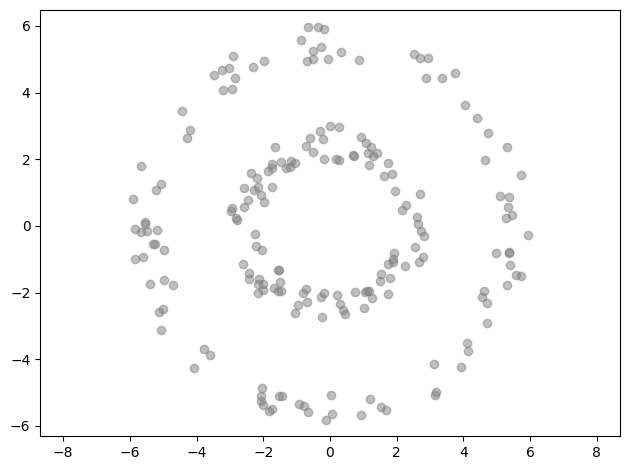

In [33]:
sample1 = gen_ring_sample((0,0), 2, 3, 100)
sample2 = gen_ring_sample((0,0), 5, 6, 100)

data = np.vstack((sample1, sample2))
# data = np.array(sample2)

plt.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [34]:
m = 15
n = m**2

a = 1
b = 1

model = SOM(n, a, b)
model.fit(data, n_iter=500)

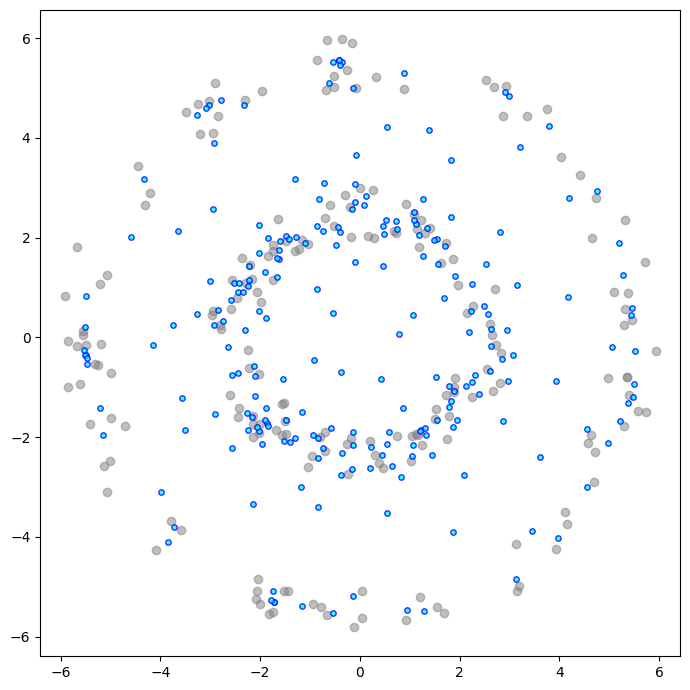

In [35]:
fig = plt.figure(figsize=(7,7), dpi=100)
ax = fig.add_subplot()


ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)
ax.scatter(model.p[:, 0], model.p[:, 1], s=15,
                 c='cyan', edgecolors='blue', alpha=0.8)

plt.axis('equal')
plt.tight_layout()
plt.show()

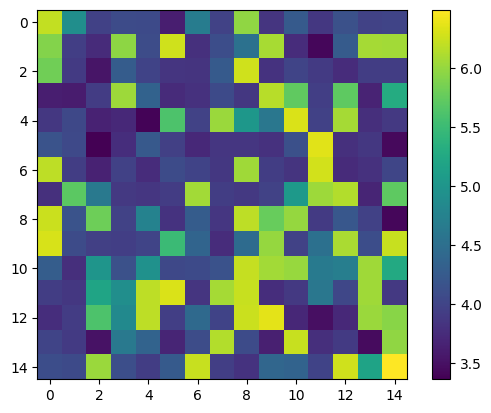

In [36]:
avg_dists = np.zeros(n)

for i,p in enumerate(model.p):
    avg_dists[i] = np.mean(np.linalg.norm(p-model.p, axis=1))

img = plt.imshow(avg_dists.reshape((m,m)))

plt.colorbar(img)

plt.show()

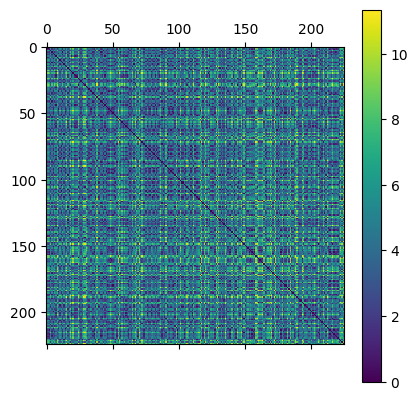

In [37]:
distances = np.array(
    [[np.linalg.norm(a-b) for b in model.p] for a in model.p]
)

img = plt.matshow(distances)
plt.colorbar(img)
plt.show()

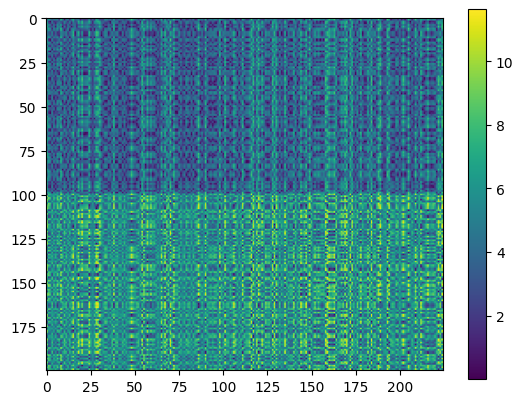

In [38]:
y = []
for x in data:
    # a = np.exp(-np.linalg.norm(x-model.p, axis=1))
    a = np.linalg.norm(x-model.p, axis=1)
    y.append(a)
    

img = plt.imshow(y)

plt.colorbar(img)

plt.show()